In [36]:
import pandas as pd
import re
import datetime

# plotting
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# for sankey diagram 
from sankey import genSankey
import plotly
#import plotly.plotly as py
import chart_studio.plotly as py

# pandas display 
pd.options.display.max_colwidth = 100

In [2]:
from iwantout import load_and_transform_raw_data,save_outputs_from_generator
%load_ext autoreload
%autoreload 2

In [3]:
# test data
transformed_csv = 'output/test_transformed.csv'

## Load transfromed data

In [27]:
df = pd.read_csv(transformed_csv)

## Trend analysis

In [28]:
df['created_dt'] = pd.to_datetime(df['created_dt'])

In [29]:
 df['start_of_week'] = df['created_dt'] - df['created_dt'].dt.weekday.astype('timedelta64[D]')

In [34]:
df_trend_analysis = df.groupby(['start_of_week', 'destination_regions']).agg('count')[['index']].reset_index().rename({'index': 'count'}, axis='columns')

In [54]:
destination_regions = list(df['destination_regions'].dropna().unique())

In [55]:
colours = ['b','g','r', 'm', 'y','k', 'w','c']

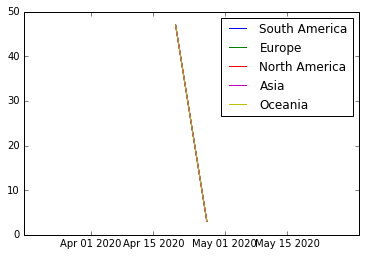

In [58]:
time_unit = 'start_of_week'
fig, ax = plt.subplots()

for i in range(len(destination_regions)):
    dest = destination_regions[i]
    df_plot = df_trend_analysis[df_trend_analysis['destination_regions'] == dest]
    x, y = df_plot[time_unit], df_plot['count']
    
    
    ax.plot(x1, y1, colours[i], label=dest)

ax.axis('equal')
leg = ax.legend();

## Sankey diagram

In [58]:
agg_cols = ['origin_region', 'origin_country', 'destination_regions', 'destination_countries']
grouped = df.groupby(agg_cols).count()['index']

In [59]:
grouped = grouped.reset_index().rename({'index': 'count'}, axis='columns')

In [65]:
grouped["origin_region"] = grouped.apply(lambda x: "Origin: " + x['origin_region'], axis = 1)

In [66]:
grouped["origin_country"] = grouped.apply(lambda x: "Origin: " + x['origin_country'], axis = 1)

In [67]:
grouped["destination_regions"] = grouped.apply(lambda x: "Destination: " + x['destination_regions'], axis = 1)

In [68]:
grouped["destination_countries"] = grouped.apply(lambda x: "Destination: " + x['destination_countries'], axis = 1)

In [95]:
fig = genSankey(grouped,cat_cols=agg_cols,value_cols='count',title='Where do redditors want to go?')
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

## Keyword extraction

In [87]:
from process_text import tokenize, remove_special_characters,spacy_tokeniser, clean_my_string

In [212]:
def generate_document_by_region(dest_region):
    contents = list(df[df['destination_regions'] == dest_region]['contents'].values)

    # remove duplicates (exist because of exploded destination)
    contents = list(set(contents))
    
    # clean and combine all contents into one list 
    cleaned_combined = []
    for c in contents:
        cleaned = clean_my_string(c)
        cleaned_combined += cleaned
    
    return cleaned_combined

In [ ]:
# TODO find all regions 

In [215]:
text_by_region = []
for dest_region in ["Europe", "Asia"]:
    cleaned_combined = generate_document_by_region(dest_region)
    text_by_region.append(" ".join(cleaned_combined))
    

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(tokenizer=clean_my_string)
X = vectorizer.fit_transform(text_by_region)
feature_names = vectorizer.get_feature_names()

In [228]:
k = 10
top = []
for x in X.toarray():
    pair = dict()
    
    n = np.array(x)
    
    # top k indexes with highest value
    topk = np.argsort(n)[-k:]
    tfidf = n[topk]
    key = list(np.array(feature_names)[topk])
    
    for i,j in zip(key,tfidf):
        pair[i] = j
    top.append(pair)


In [244]:
top

[{'want': 0.13100088220547024,
  'find': 0.13100088220547024,
  'know': 0.1350946597743912,
  'like': 0.14737599248115402,
  'job': 0.1555635476189959,
  've': 0.15965732518791687,
  'live': 0.19240754573928442,
  'country': 0.2087826560149682,
  'year': 0.24562665413525672,
  'work': 0.30293954010014995},
 {'major': 0.12149528148388125,
  'like': 0.12149528148388125,
  'thailand': 0.12806803419403126,
  'archaeology': 0.12806803419403126,
  'want': 0.15186910185485156,
  'currently': 0.15186910185485156,
  'study': 0.1822429222258219,
  'work': 0.2429905629677625,
  'jewish': 0.2561360683880625,
  'year': 0.2733643833387328}]

In [242]:
("find" + " ") * 3

'find find find '

In [245]:
for t in top:
    String = ""
    for word in t.keys():
        String += (word + " ") * int(t[word] * 100)
        #print(String)

(-0.5, 1439.5, 1079.5, -0.5)

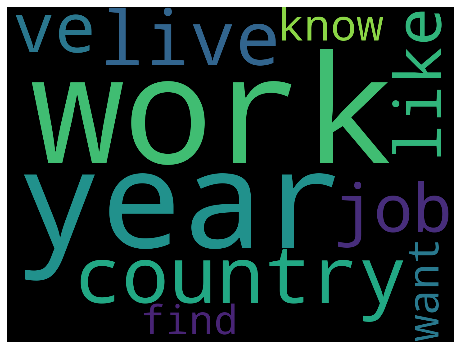

In [249]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate_from_frequencies(top[0])
plt.figure(figsize=(8, 8))
plt.imshow(cloud)
plt.axis('off')